# Pipeline for High-z Radio Galaxies 07: Application of full pipeline for prediction with naive thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Functions to predict values

In [3]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict(catalog_df.loc[:, 'Score_0'])
    cal_class  = np.array(pred_probs < (1 - cal_threshold)).astype(int)
    catalog_df['Prob_no_star']  = pred_probs
    catalog_df['pred_star_cal'] = cal_class
    return catalog_df

In [4]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    pred_probs = cal_AGN_gal_model.predict(catalog_df.loc[:, 'Score_AGN'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_AGN']       = pred_probs
    catalog_df['pred_class_cal'] = cal_class
    return catalog_df

In [5]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    pred_probs = cal_radio_model.predict(catalog_df.loc[:, 'Score_radio'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_radio']     = pred_probs
    catalog_df['pred_radio_cal'] = cal_class
    return catalog_df

In [6]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [7]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [8]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [9]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [10]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [11]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

In [12]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    return catalog_df

---

## Reading data

Flags.

In [13]:
save_plot_flag      = True
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0 ***
use_calibration     = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [14]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train

In [15]:
if used_area != 'S82':
    compare_A17_flag = False

In [16]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [17]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [18]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [19]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [20]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [21]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [22]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

Show early statistics of confirmed sources

In [23]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the S82 field, there are 3,304 confirmed sources.
504 of them are galaxies.
2,800 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [24]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
    print('Shape of used data in HETDEX')
    print('-' * 65)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 65)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df, 'Calibration': calibration_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Split data if not from HETDEX

In [25]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [26]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (3304, 99)
--------------------------------------------------
Thus, it has 3,304 sources and 99 features.


Discard minor features.

In [27]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [28]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)     # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # 
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)        # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)    # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)          # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)   # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)   # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with naive thresholds ($0.5$).

In [29]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, cal_star_clf, gv.naive_star_thresh, gv.naive_star_thresh)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, cal_star_clf, gv.naive_star_thresh, gv.naive_star_thresh)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    full_catalog_df['Prob_no_star']  = 1
    full_catalog_df['pred_star_cal'] = 0
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['pred_star_cal']  = 0
    unknown_cat_df['Score_no_star']  = 1
    unknown_cat_df['Prob_no_star']   = 1

In [30]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)

In [31]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)

In [32]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)

Scores before applying further z models

In [33]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [34]:
if use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN_prob   = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1) &\
                             temp_filt_pred_nstr_prob
sigma_mad_prob_early       = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early      = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_prob_early         = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early    = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
out_frac_prob_early        = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])

In [35]:
temp_filt_high_z_rAGN       = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_early_hiz         = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz        = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz           = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz      = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz          = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

temp_filt_high_z_rAGN_prob  = temp_filt_pred_rAGN_prob * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_early_hiz    = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early_hiz   = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_prob_early_hiz      = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early_hiz = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
out_frac_prob_early_hiz     = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])

In [36]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

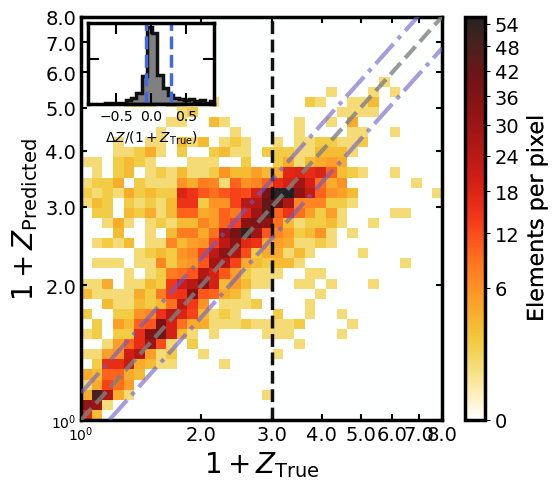

In [37]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + Z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Additional columns with radio AGN prediction as a whole.

In [38]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_star_cal']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_no_star'] *\
                                        full_catalog_df.loc[:, 'Prob_AGN'] *\
                                        full_catalog_df.loc[:, 'Prob_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [39]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['pred_prob_rAGN']     = np.array(unknown_cat_df.loc[:, 'pred_star_cal']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']
unknown_cat_df['Prob_rAGN']          = unknown_cat_df.loc[:, 'Prob_no_star'] *\
                                       unknown_cat_df.loc[:, 'Prob_AGN'] *\
                                       unknown_cat_df.loc[:, 'Prob_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [40]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'pred_class_cal', 'LOFAR_detect', 'pred_radio', 'pred_radio_cal', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,pred_class_cal,LOFAR_detect,pred_radio,pred_radio_cal,Z,pred_Z
count,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000,3304.000000
mean,0.847458,0.731538,0.735775,0.316283,0.332627,0.339891,1.323084,1.500736
std,0.359600,0.443227,0.440987,0.465095,0.471226,0.473744,0.880608,0.823235
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.624043,0.808050
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.209500,1.572150
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.895500,2.129000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.780000,4.684700


##### Include AGN detection criteria from literature

In [41]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [42]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_gal_t            = np.array(full_catalog_df.loc[:, 'class'] == 0)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_t            = np.array(full_catalog_df.loc[:, 'class'] == 2)
filter_radio_t          = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
num_str_t               = np.sum(filter_str_t)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(filter_gal_t)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(filter_radio_t)
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [43]:
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_str_p                 = np.sum(full_catalog_df.loc[:, 'pred_star'] == 1)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Some metrics for predicted classes based on probabilities (not scores).

In [44]:
if use_zeroth_model:
    filter_non_str_prob_p = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_prob_p = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_prob_p   = full_catalog_df['pred_prob_rAGN']
filt_hiz_rAGN_prob_p      = filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_prob_p         = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_prob_p
filter_radio_prob_p       = np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_prob_p      = filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)

num_AGN_prob_p            = np.sum(filter_AGN_prob_p)
num_gal_prob_p            = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_prob_p)
num_radio_prob_p          = np.sum(filter_radio_prob_p)
num_radio_AGN_prob_p      = np.sum(filter_radio_AGN_prob_p)
num_rAGN_MQC_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_prob_p       = np.sum(filter_radio_AGN_prob_p) - np.sum(filter_radio_AGN_t)

In [45]:
if use_zeroth_model:
    filter_non_str_unk_p      = np.array(unknown_cat_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_p      = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_p        = unknown_cat_df['pred_radio_AGN']
filt_hiz_rAGN_unk_p           = filter_radio_AGN_unk_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_p              = np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_p            = np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_unk_p           = filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)
num_str_unk_p                 = np.sum(unknown_cat_df.loc[:, 'pred_star'] == 1)
num_AGN_unk_p                 = np.sum(filter_AGN_unk_p)
num_gal_unk_p                 = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_p               = np.sum(filter_radio_unk_p)
num_radio_AGN_unk_p           = np.sum(filter_radio_AGN_unk_p)
num_rAGN_MQC_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))

In [46]:
if use_zeroth_model:
    filter_non_str_unk_prob_p = np.array(unknown_cat_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_prob_p = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_prob_p   = unknown_cat_df['pred_prob_rAGN']
filt_hiz_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_prob_p         = np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_unk_prob_p
filter_radio_unk_prob_p       = np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)

num_AGN_unk_prob_p            = np.sum(filter_AGN_unk_prob_p)
num_gal_unk_prob_p            = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_unk_prob_p)
num_radio_unk_prob_p          = np.sum(filter_radio_unk_prob_p)
num_radio_AGN_unk_prob_p      = np.sum(filter_radio_AGN_unk_prob_p)
num_rAGN_MQC_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [47]:
if use_zeroth_model:
    cm_str = gf.conf_mat_func(full_catalog_df.loc[:, 'is_str'], full_catalog_df.loc[:, 'pred_star'])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [48]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_class'])

cm_AGN_prob = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_class_cal'])

Confusion matrices from literature AGN criteria.

In [49]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'S12_AGN'])

cm_AGN_M12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'])

cm_AGN_M16 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'])

cm_AGN_B18 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [50]:
cm_radio = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'],\
        full_catalog_df.loc[filter_AGN_p, 'pred_radio'])

cm_radio_prob = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_prob_p, 'LOFAR_detect'],\
        full_catalog_df.loc[filter_AGN_prob_p, 'pred_radio_cal'])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [51]:
cm_rAGN = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_radio_AGN'])

cm_rAGN_prob = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_prob_rAGN'])

Metrics from redshift predictions.

In [52]:
sigma_mad_field            = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

sigma_mad_prob_field       = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field      = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_prob_field         = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field    = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
out_frac_prob_field        = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])

In [53]:
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

filt_high_z_rAGN_prob_p         = filter_radio_AGN_prob_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_prob_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
out_frac_prob_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])

Plot histograms for scores.

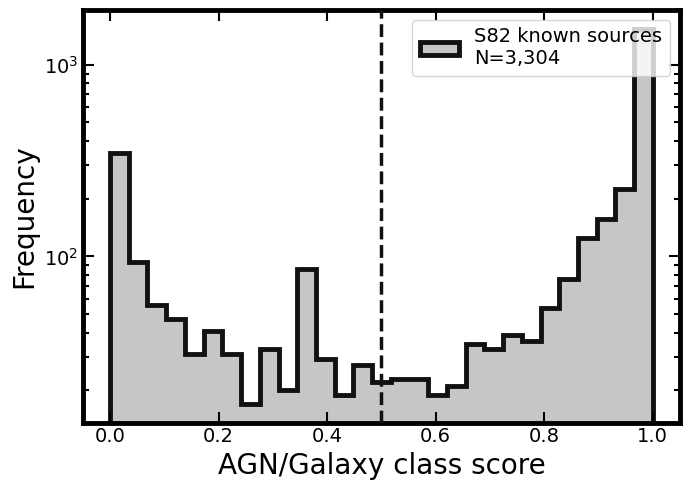

In [54]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_naive_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

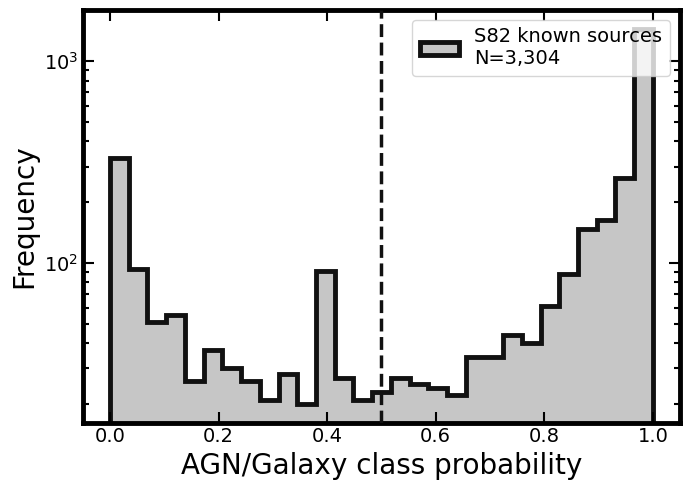

In [55]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_naive_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

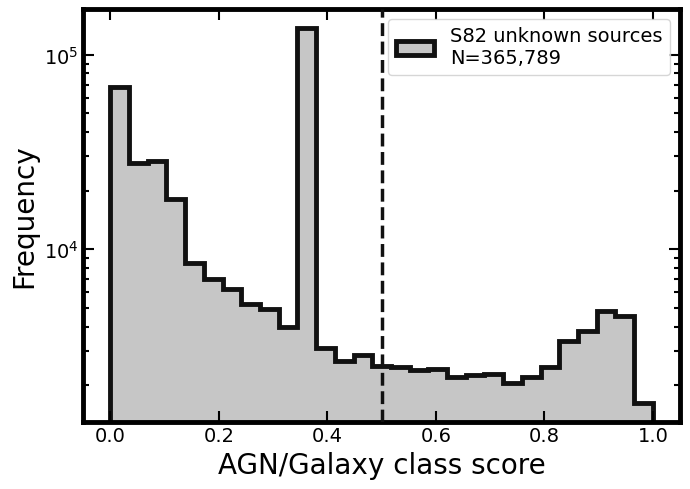

In [56]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_naive_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

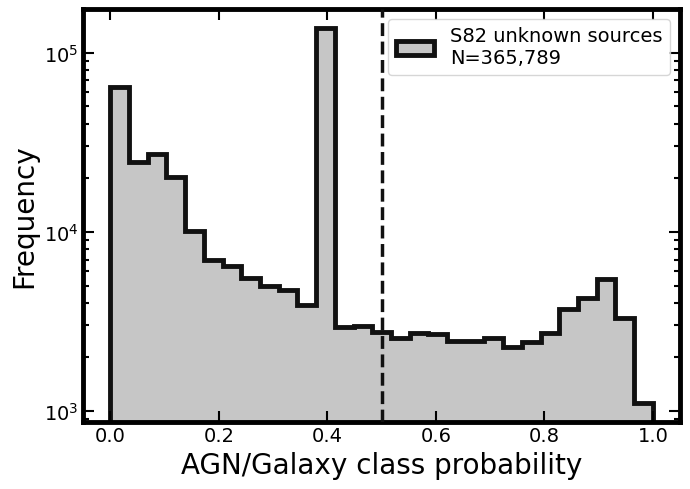

In [57]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_naive_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

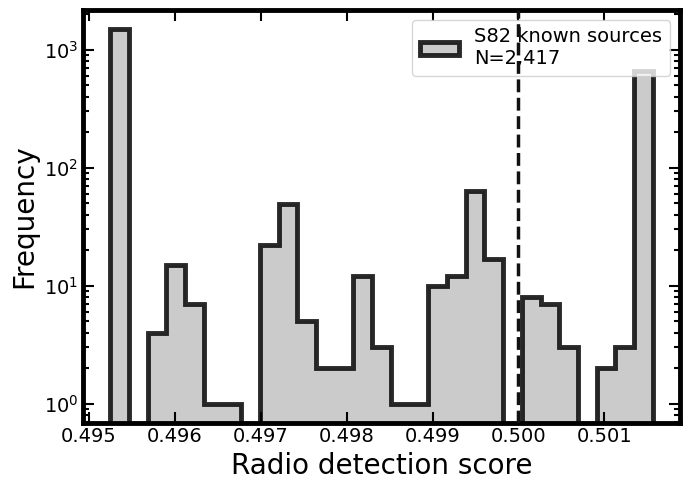

In [58]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_naive_scores_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

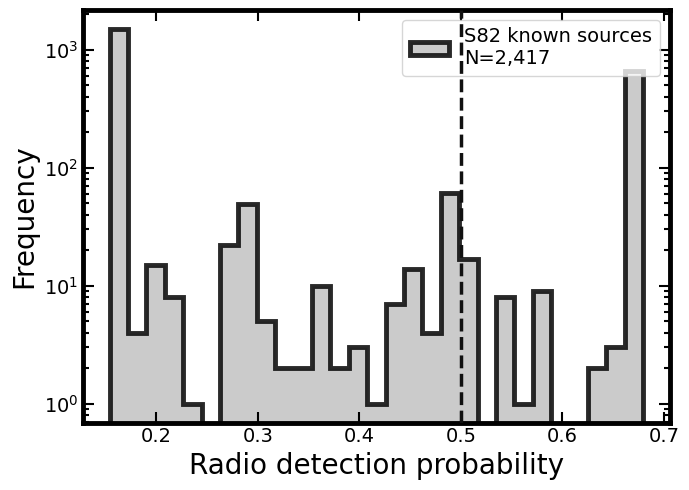

In [59]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_naive_prob_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

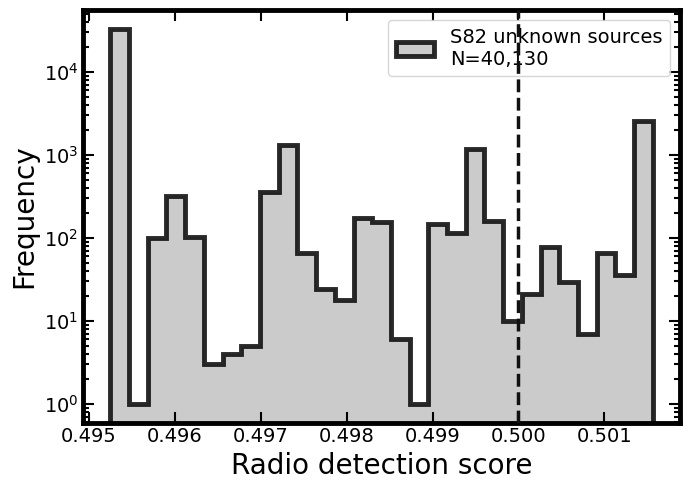

In [60]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_naive_scores_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

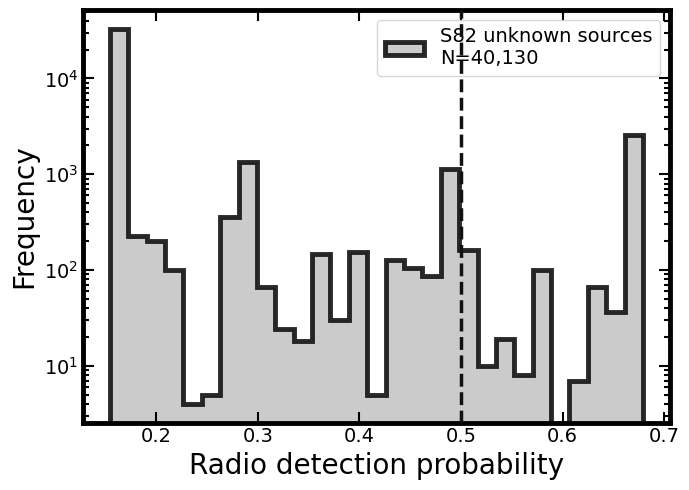

In [61]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_naive_probs_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

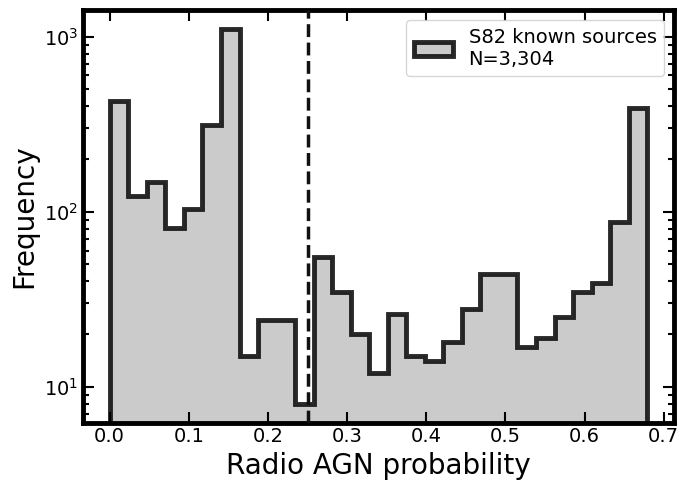

In [62]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
max_score       = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_naive_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

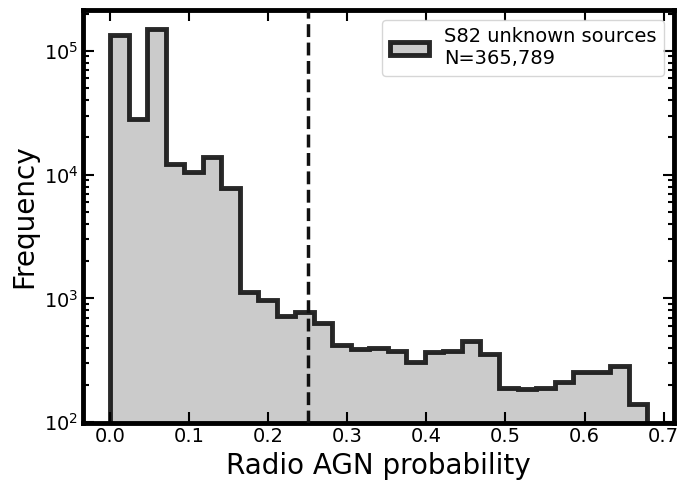

In [63]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_naive_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

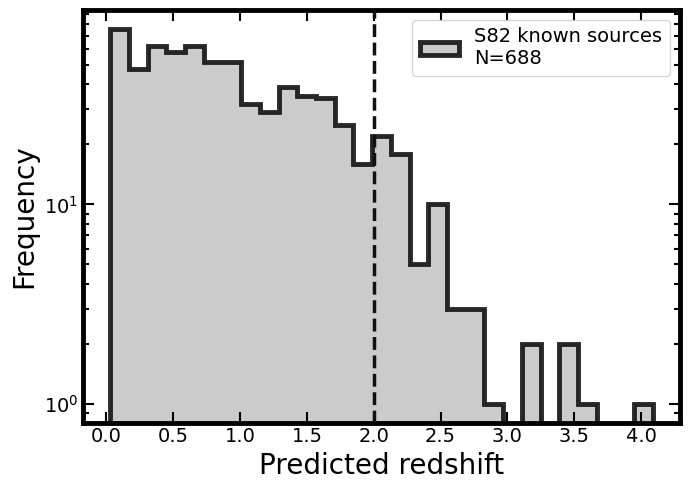

In [64]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_p)

ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_naive_redshift_rAGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

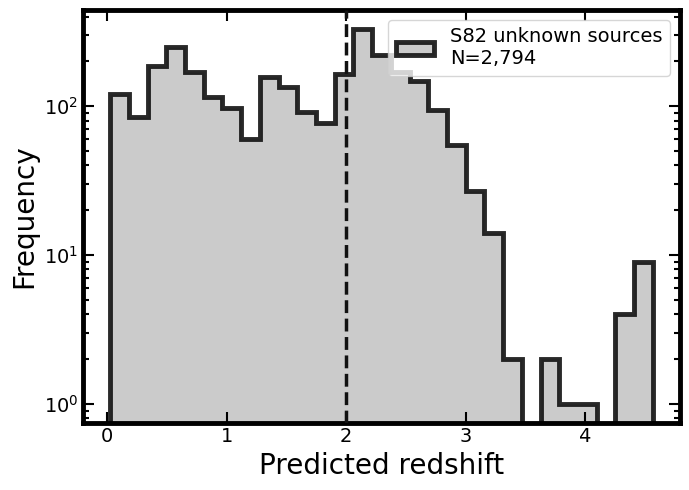

In [65]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_naive_redshift_rAGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

In [66]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'LOFAR_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
print('Predictions for known sources:')
display(full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe())
print('\nPredictions for unknown sources:')
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, displayed_cols].describe())

Predictions for known sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,688.000000,688.0,688.000000,688.0,688.000000,688.000000
mean,0.991279,1.0,0.611919,1.0,0.973314,0.975885
std,0.093045,0.0,0.487668,0.0,0.791577,0.696948
min,0.000000,1.0,0.000000,1.0,0.018000,0.028000
25%,1.000000,1.0,0.000000,1.0,0.329000,0.414275
50%,1.000000,1.0,1.000000,1.0,0.789500,0.821050
75%,1.000000,1.0,1.000000,1.0,1.439000,1.463825
max,1.000000,1.0,1.000000,1.0,5.469000,4.088400



Predictions for unknown sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,2794.0,2794.0,2794.000000,2794.0,45.000000,2794.000000
mean,0.5,1.0,0.212598,1.0,0.727412,1.554422
std,0.0,0.0,0.409219,0.0,0.689686,0.875472
min,0.5,1.0,0.000000,1.0,0.000120,0.025300
25%,0.5,1.0,0.000000,1.0,0.300000,0.690925
50%,0.5,1.0,0.000000,1.0,0.500000,1.609800
75%,0.5,1.0,0.000000,1.0,0.800000,2.245600
max,0.5,1.0,1.000000,1.0,3.100000,4.567400


Add individual metrics for redshift

In [67]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [68]:
str_0_t     = f'Out of {total_size:,} initially known sources in {used_area},\n'
str_1_t     = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t     = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t     = f'Also, {num_radio_AGN_t:,} AGN are detected in radio (i.e. Radio Galaxies).'

str_0_kno_p = f'Out of {len(full_catalog_df):,} initially known sources in {used_area},\n'
str_1_kno_p = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_kno_p = f'{num_str_p:,} are predicted as SDSS-DR16 stars and {num_AGN_p:,} are MQC AGN.\n'
str_3_kno_p = f'Also, {num_radio_AGN_p:,} AGN are predicted to bedetected in radio.'

str_0_unk_p = f'Out of {len(unknown_cat_df):,} initially unknown sources in {used_area},\n'
str_1_unk_p = f'{num_gal_unk_p:,} are predicted to be galaxies. On the other side,\n'
str_2_unk_p = f'{num_str_unk_p:,} are predicted as SDSS-DR16 stars and {num_AGN_unk_p:,} are MQC AGN.\n'
str_3_unk_p = f'Also, {num_radio_AGN_unk_p:,} AGN are predicted to be detected in radio.'

In [69]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)

print('-' * 60)
print(str_0_kno_p + str_1_kno_p + str_2_kno_p + str_3_kno_p)
print('-' * 60)

print('-' * 60)
print(str_0_unk_p + str_1_unk_p + str_2_unk_p + str_3_unk_p)
print('-' * 60)

------------------------------------------------------------
Out of 3,304 initially known sources in S82,
504 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 2,800 are MQC AGN.
Also, 934 AGN are detected in radio (i.e. Radio Galaxies).
------------------------------------------------------------
------------------------------------------------------------
Out of 3,304 initially known sources in S82,
887 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 2,417 are MQC AGN.
Also, 688 AGN are predicted to bedetected in radio.
------------------------------------------------------------
------------------------------------------------------------
Out of 365,789 initially unknown sources in S82,
325,659 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 40,130 are MQC AGN.
Also, 2,794 AGN are predicted to be detected in radio.
-------------------------------------------------------

In [70]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'LOFAR_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

# cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
# cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']
cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Score_rAGN', 'Z', 'pred_Z']
cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Score_rAGN', 'pred_Z']

In [71]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [72]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit

Display properties of predicted Radio AGN in known sample.

In [73]:
disp_table_known = full_catalog_df.loc[filter_radio_AGN_prob_p, cols_4_table_pred_known].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_known)

,RA_ICRS,DE_ICRS,band_num,class,Score_AGN,LOFAR_detect,Score_radio,Score_rAGN,Z,pred_Z
249970,345.687500,-0.556187,9,1.0,0.878216,0,0.501565,0.440482,3.761,4.0884
60228,16.550922,0.322279,9,1.0,0.989221,0,0.501565,0.496159,3.110,3.6576
94386,335.210785,0.996780,9,1.0,0.975818,0,0.501565,0.489436,2.601,3.4468
259354,28.415033,-0.184724,9,1.0,0.729141,1,0.501565,0.365712,4.207,3.3944
262137,29.582396,-0.206112,9,1.0,0.850459,1,0.501565,0.426560,3.286,3.2392


LaTeX display of same table

In [74]:
display(disp_table_known.to_latex())

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &   DE\\_ICRS &  band\\_num &  class &  Score\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Score\\_rAGN &      Z &  pred\\_Z \\\\\n\\midrule\n249970 &  345.687500 & -0.556187 &         9 &    1.0 &   0.878216 &             0 &     0.501565 &    0.440482 &  3.761 &  4.0884 \\\\\n60228  &   16.550922 &  0.322279 &         9 &    1.0 &   0.989221 &             0 &     0.501565 &    0.496159 &  3.110 &  3.6576 \\\\\n94386  &  335.210785 &  0.996780 &         9 &    1.0 &   0.975818 &             0 &     0.501565 &    0.489436 &  2.601 &  3.4468 \\\\\n259354 &   28.415033 & -0.184724 &         9 &    1.0 &   0.729141 &             1 &     0.501565 &    0.365712 &  4.207 &  3.3944 \\\\\n262137 &   29.582396 & -0.206112 &         9 &    1.0 &   0.850459 &             1 &     0.501565 &    0.426560 &  3.286 &  3.2392 \\\\\n\\bottomrule\n\\end{tabular}\n'

Display properties predicted Radio AGN in unknown sample.

In [75]:
disp_table_unk = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, cols_4_table_pred_unknown].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_unk)

,RA_ICRS,DE_ICRS,band_num,Score_AGN,LOFAR_detect,Score_radio,Score_rAGN,pred_Z
189511,340.342285,0.029702,8,0.996063,0,0.501565,0.499590,4.5674
115779,336.125732,0.470109,8,0.970989,0,0.501565,0.487014,4.5639
177651,340.529358,0.491929,8,0.954704,0,0.501565,0.478846,4.5639
197450,344.056549,0.184245,8,0.943564,0,0.501565,0.473259,4.5639
365788,331.351929,0.107907,8,0.815927,0,0.501399,0.409105,4.5542


LaTeX display of same table

In [76]:
display(disp_table_unk.to_latex())

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &   DE\\_ICRS &  band\\_num &  Score\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Score\\_rAGN &  pred\\_Z \\\\\n\\midrule\n189511 &  340.342285 &  0.029702 &         8 &   0.996063 &             0 &     0.501565 &    0.499590 &  4.5674 \\\\\n115779 &  336.125732 &  0.470109 &         8 &   0.970989 &             0 &     0.501565 &    0.487014 &  4.5639 \\\\\n177651 &  340.529358 &  0.491929 &         8 &   0.954704 &             0 &     0.501565 &    0.478846 &  4.5639 \\\\\n197450 &  344.056549 &  0.184245 &         8 &   0.943564 &             0 &     0.501565 &    0.473259 &  4.5639 \\\\\n365788 &  331.351929 &  0.107907 &         8 &   0.815927 &             0 &     0.501399 &    0.409105 &  4.5542 \\\\\n\\bottomrule\n\\end{tabular}\n'

Confusion matrix for AGN/galaxy prediction on all sources

In [77]:
MCC_AGN              = gf.MCC_from_CM(cm_AGN)
ACC_AGN              = gf.ACC_from_CM(cm_AGN)
Fb_AGN               = gf.Fb_from_CM(cm_AGN)
Precision_AGN        = gf.Precision_from_CM(cm_AGN)
Recall_AGN           = gf.Recall_from_CM(cm_AGN)

MCC_AGN_prob         = gf.MCC_from_CM(cm_AGN_prob)
ACC_AGN_prob         = gf.ACC_from_CM(cm_AGN_prob)
Fb_AGN_prob          = gf.Fb_from_CM(cm_AGN_prob)
Precision_AGN_prob   = gf.Precision_from_CM(cm_AGN_prob)
Recall_AGN_prob      = gf.Recall_from_CM(cm_AGN_prob)

Confusion matrix for radio detection prediction on all predicted AGN

In [78]:
MCC_radio            = gf.MCC_from_CM(cm_radio)
ACC_radio            = gf.ACC_from_CM(cm_radio)
Fb_radio             = gf.Fb_from_CM(cm_radio)
Precision_radio      = gf.Precision_from_CM(cm_radio)
Recall_radio         = gf.Recall_from_CM(cm_radio)

MCC_radio_prob       = gf.MCC_from_CM(cm_radio_prob)
ACC_radio_prob       = gf.ACC_from_CM(cm_radio_prob)
Fb_radio_prob        = gf.Fb_from_CM(cm_radio_prob)
Precision_radio_prob = gf.Precision_from_CM(cm_radio_prob)
Recall_radio_prob    = gf.Recall_from_CM(cm_radio_prob)

Confusion matrix for radio AGN detection prediction.

In [79]:
MCC_radio_AGN            = gf.MCC_from_CM(cm_rAGN)
ACC_radio_AGN            = gf.ACC_from_CM(cm_rAGN)
Fb_radio_AGN             = gf.Fb_from_CM(cm_rAGN)
Precision_radio_AGN      = gf.Precision_from_CM(cm_rAGN)
Recall_radio_AGN         = gf.Recall_from_CM(cm_rAGN)

MCC_radio_AGN_prob       = gf.MCC_from_CM(cm_rAGN_prob)
ACC_radio_AGN_prob       = gf.ACC_from_CM(cm_rAGN_prob)
Fb_radio_AGN_prob        = gf.Fb_from_CM(cm_rAGN_prob)
Precision_radio_AGN_prob = gf.Precision_from_CM(cm_rAGN_prob)
Recall_radio_AGN_prob    = gf.Recall_from_CM(cm_rAGN_prob)

Join metrics for classification.

In [80]:
metrics_classif      = np.array([[np.sum(filter_known_spec), Fb_AGN,       MCC_AGN,       Precision_AGN,       Recall_AGN,       ACC_AGN],\
                                 [np.sum(filter_AGN_p),      Fb_radio,     MCC_radio,     Precision_radio,     Recall_radio,     ACC_radio],\
                                 [np.sum(filter_known_spec), Fb_radio_AGN, MCC_radio_AGN, Precision_radio_AGN, Recall_radio_AGN, ACC_radio_AGN]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

metrics_classif_prob      = np.array([[np.sum(filter_known_spec), Fb_AGN_prob,       MCC_AGN_prob,       Precision_AGN_prob,       Recall_AGN_prob,       ACC_AGN_prob],\
                                      [np.sum(filter_AGN_prob_p), Fb_radio_prob,     MCC_radio_prob,     Precision_radio_prob,     Recall_radio_prob,     ACC_radio_prob],\
                                      [np.sum(filter_known_spec), Fb_radio_AGN_prob, MCC_radio_AGN_prob, Precision_radio_AGN_prob, Recall_radio_AGN_prob, ACC_radio_AGN_prob]])
metrics_classif_prob_df   = pd.DataFrame(data=metrics_classif_prob, columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

Confusion matrices for AGN criteria from literature

In [81]:
MCC_AGN_S12          = gf.MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = gf.ACC_from_CM(cm_AGN_S12)
Fb_AGN_S12           = gf.Fb_from_CM(cm_AGN_S12)
Precision_AGN_S12    = gf.Precision_from_CM(cm_AGN_S12)
Recall_AGN_S12       = gf.Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = gf.MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = gf.ACC_from_CM(cm_AGN_M12)
Fb_AGN_M12           = gf.Fb_from_CM(cm_AGN_M12)
Precision_AGN_M12    = gf.Precision_from_CM(cm_AGN_M12)
Recall_AGN_M12       = gf.Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = gf.MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = gf.ACC_from_CM(cm_AGN_M16)
Fb_AGN_M16           = gf.Fb_from_CM(cm_AGN_M16)
Precision_AGN_M16    = gf.Precision_from_CM(cm_AGN_M16)
Recall_AGN_M16       = gf.Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = gf.MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = gf.ACC_from_CM(cm_AGN_B18)
Fb_AGN_B18           = gf.Fb_from_CM(cm_AGN_B18)
Precision_AGN_B18    = gf.Precision_from_CM(cm_AGN_B18)
Recall_AGN_B18       = gf.Recall_from_CM(cm_AGN_B18)

metrics_AGN_criteria    = np.array([[Fb_AGN_S12,        Fb_AGN_M12,        Fb_AGN_M16,        Fb_AGN_B18],\
                                    [MCC_AGN_S12,       MCC_AGN_M12,       MCC_AGN_M16,       MCC_AGN_B18],\
                                    [Precision_AGN_S12, Precision_AGN_M12, Precision_AGN_M16, Precision_AGN_B18],\
                                    [Recall_AGN_S12,    Recall_AGN_M12,    Recall_AGN_M16,    Recall_AGN_B18],\
                                    [ACC_AGN_S12,       ACC_AGN_M12,       ACC_AGN_M16,       ACC_AGN_B18]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18'])

Join metrics for regression.

In [82]:
size_rAGN    = np.sum(filter_radio_AGN_p)
size_rAGN_hz = np.sum(filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z    = np.array([[size_rAGN, sigma_mad_early, sigma_nmad_early, sigma_z_early, sigma_z_norm_early, out_frac_early],\
                         [size_rAGN, sigma_mad_field, sigma_nmad_field, sigma_z_field, sigma_z_norm_field, out_frac_field],\
                         [size_rAGN_hz, sigma_mad_early_hiz, sigma_nmad_early_hiz, sigma_z_early_hiz, sigma_z_norm_early_hiz, out_frac_early_hiz],\
                         [size_rAGN_hz, sigma_mad_field_hiz, sigma_nmad_field_hiz, sigma_z_field_hiz, sigma_z_norm_field_hiz, out_frac_field_hiz]])
metrics_z_df = pd.DataFrame(data=metrics_z,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

size_rAGN_prob    = np.sum(filter_radio_AGN_prob_p)
size_rAGN_prob_hz = np.sum(filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z_prob    = np.array([[size_rAGN_prob, sigma_mad_prob_early, sigma_nmad_prob_early, sigma_z_prob_early,\
                               sigma_z_norm_prob_early, out_frac_prob_early],\
                         [size_rAGN_prob, sigma_mad_prob_field, sigma_nmad_prob_field, sigma_z_prob_field,\
                          sigma_z_norm_prob_field, out_frac_prob_field],\
                         [size_rAGN_prob_hz, sigma_mad_prob_early_hiz, sigma_nmad_prob_early_hiz, sigma_z_prob_early_hiz,\
                          sigma_z_norm_prob_early_hiz, out_frac_prob_early_hiz],\
                         [size_rAGN_prob_hz, sigma_mad_prob_field_hiz, sigma_nmad_prob_field_hiz, sigma_z_prob_field_hiz,\
                          sigma_z_norm_prob_field_hiz, out_frac_prob_field_hiz]])
metrics_z_prob_df = pd.DataFrame(data=metrics_z_prob,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

Print metrics

In [83]:
print('Metrics for classification steps along the pipeline using scores to obtain classes.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df.drop(columns=['Accuracy']))

Metrics for classification steps along the pipeline using scores to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,3304,0.9046,0.6225,0.9830,0.8486
Radio,2417,0.5744,0.3972,0.6119,0.5468
Radio AGN,3304,0.5081,0.3700,0.6076,0.4475


In [84]:
print('Metrics for classification steps along the pipeline using probabilities to obtain classes.')
metrics_classif_prob_df.loc[:, 'Sample'] = metrics_classif_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_prob_df.drop(columns=['Accuracy']))

Metrics for classification steps along the pipeline using probabilities to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,3304,0.9073,0.6278,0.9827,0.8532
Radio,2431,0.5791,0.3984,0.6076,0.5574
Radio AGN,3304,0.5149,0.3729,0.6034,0.4593


In [85]:
print('Metrics for AGN detection criteria (from literature).')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df.drop(columns=['Accuracy']))

Metrics for AGN detection criteria (from literature).
Sample size, N = 3,304


,F-β,MCC,Precision,Recall
S12,0.7938,0.3731,0.9522,0.6979
M12,0.4449,0.2438,0.9953,0.3054
M16,0.6479,0.3430,0.9888,0.5043
B18,0.7680,0.4428,0.9902,0.6479


In [86]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by scores')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by scores


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,688,0.1261,0.0714,0.4387,0.2308,0.1860
Two models,688,0.1261,0.0714,0.4387,0.2308,0.1860
First model high z,66,0.2017,0.0635,0.6746,0.4970,0.1515
Second model high z,66,0.2017,0.0635,0.6746,0.4970,0.1515


In [87]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities')
metrics_z_prob_df.loc[:, 'Sample'] = metrics_z_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_prob_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,711,0.1267,0.0717,0.4507,0.2360,0.1885
Two models,711,0.1267,0.0717,0.4507,0.2360,0.1885
First model high z,68,0.2017,0.0635,0.6927,0.5009,0.1618
Second model high z,68,0.2017,0.0635,0.6927,0.5009,0.1618


## Plot predictions

### Classifications based on scores

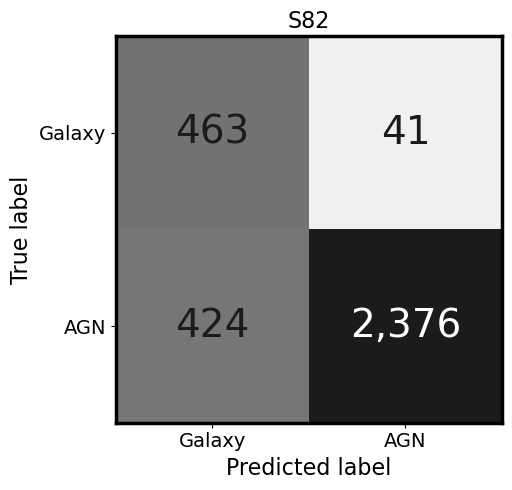

In [88]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

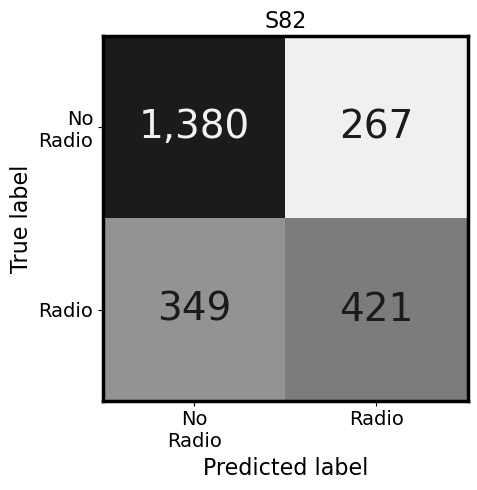

In [89]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

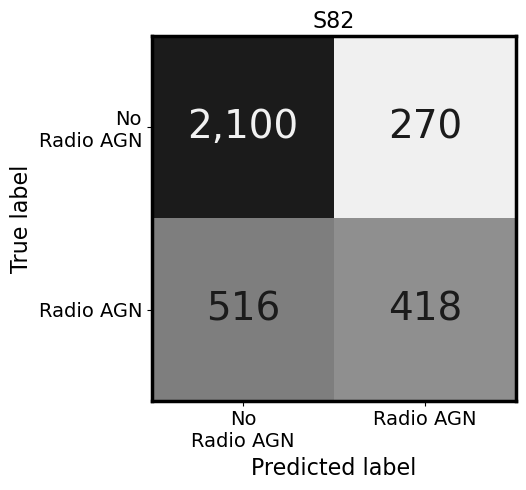

In [90]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Classifications based on probabilities

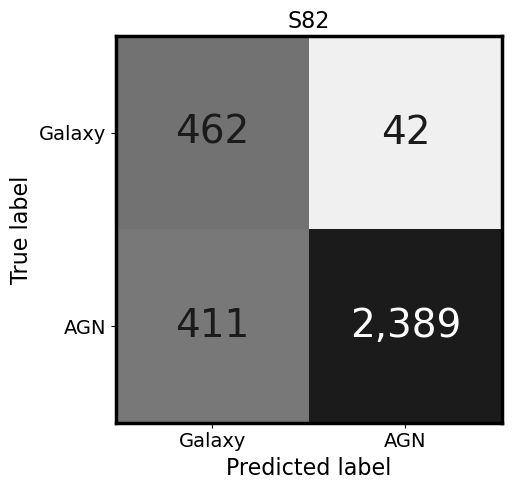

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN_prob, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_prob_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

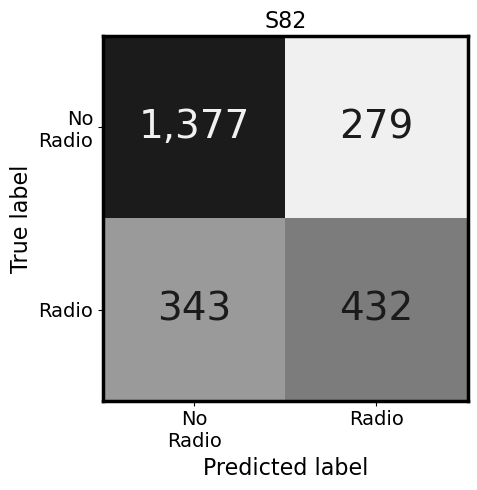

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio_prob, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_prob_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

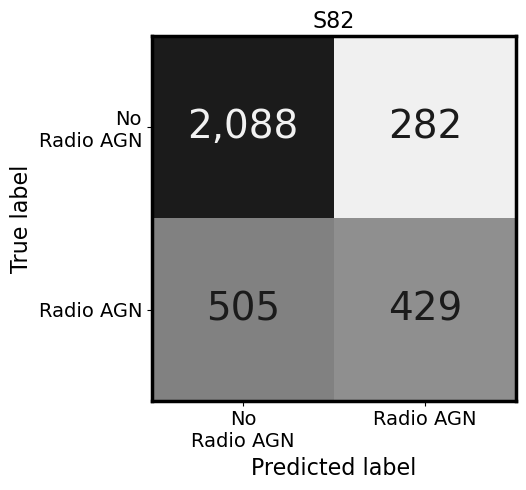

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_rAGN_prob, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_prob_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by scores

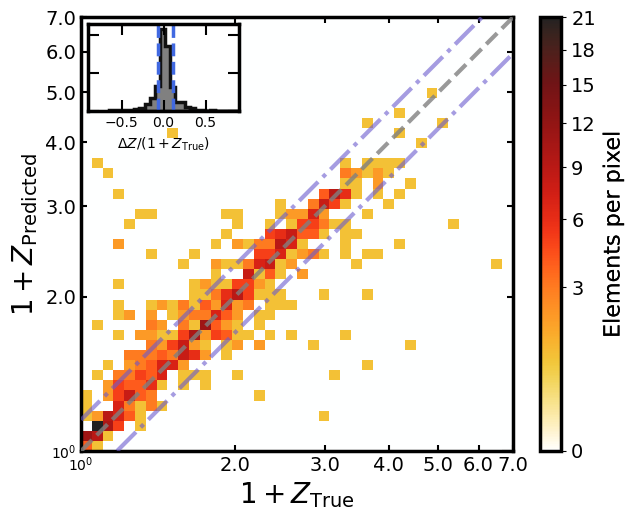

In [94]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by probabilities

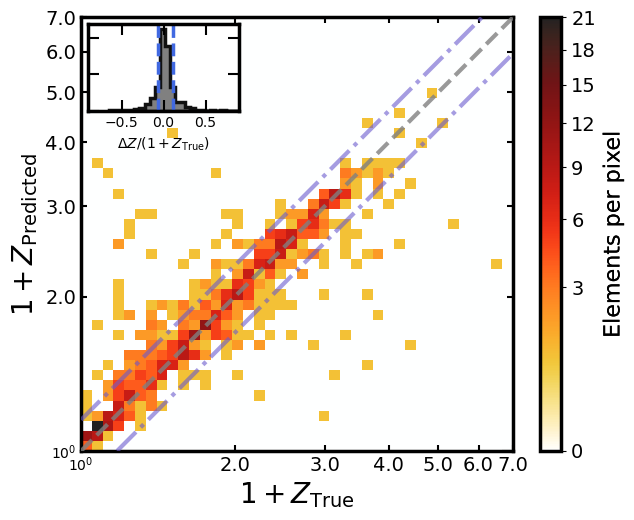

In [95]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_prob_naive_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Results from unknown sources

In [96]:
unk_summary_AGN_gal                   = unknown_cat_df.loc[:, 'Score_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_AGN_gal_probs             = unknown_cat_df.loc[:, 'Prob_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class_cal']).describe()
unk_summary_radio                     = unknown_cat_df.loc[filter_AGN_unk_p,
                                                         'Score_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_p,
                                                                                                   'pred_radio']).describe()
unk_summary_radio_probs               = unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                         'Prob_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                                                                   'pred_radio_cal']).describe()
unk_summary_z                         = unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'].describe()
unk_summary_z_probs                   = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'].describe()
unk_summary_AGN_radio                 = pd.concat([unk_summary_AGN_gal, unk_summary_AGN_gal_probs, unk_summary_radio, unk_summary_radio_probs])
unk_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
unk_summary_AGN_radio                 = unk_summary_AGN_radio.set_index('Prediction', drop=True)
unk_summary_AGN_radio.loc['Z']        = unk_summary_z
unk_summary_AGN_radio.loc['Z (prob)'] = unk_summary_z_probs

In [97]:
unk_summary_AGN_radio.loc[:, 'count'] = unk_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(unk_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,325659,0.21424,0.15730,0.00002,0.05042,0.23309,0.36791,0.49999
AGN,40130,0.77265,0.14492,0.50002,0.64391,0.80132,0.90402,0.99996
Galaxy (prob),323768,0.23129,0.16745,0.00002,0.05706,0.25288,0.39691,0.49998
AGN (prob),42021,0.76339,0.14135,0.50001,0.63655,0.78666,0.89127,0.99988
No radio,37336,0.49557,0.00099,0.49525,0.49525,0.49525,0.49525,0.49991
Radio,2794,0.50148,0.00027,0.50008,0.50156,0.50156,0.50156,0.50156
No radio (prob),38933,0.17578,0.07098,0.15423,0.15423,0.15423,0.15423,0.49545
Radio (prob),3088,0.66277,0.04455,0.50315,0.67928,0.67928,0.67928,0.67928
Z,2794,1.55442,0.87547,0.02530,0.69093,1.60980,2.24560,4.56740


In [98]:
print(f"In the unknown sources, there are {np.sum(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1):,} radio detected sources.")

In the unknown sources, there are 14,347 radio detected sources.


#### Same idea for known sample.

In [99]:
kno_summary_AGN_gal                   = full_catalog_df.loc[:, 'Score_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_AGN_gal_probs             = full_catalog_df.loc[:, 'Prob_AGN'].groupby(full_catalog_df.loc[:, 'pred_class_cal']).describe()
kno_summary_radio                     = full_catalog_df.loc[filter_AGN_p,
                                                         'Score_radio'].groupby(full_catalog_df.loc[filter_AGN_p,
                                                                                                   'pred_radio']).describe()
kno_summary_radio_probs               = full_catalog_df.loc[filter_AGN_prob_p,
                                                         'Prob_radio'].groupby(full_catalog_df.loc[filter_AGN_prob_p,
                                                                                                   'pred_radio_cal']).describe()
kno_summary_z                         = full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'].describe()
kno_summary_z_probs                   = full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'].describe()
kno_summary_AGN_radio                 = pd.concat([kno_summary_AGN_gal, kno_summary_AGN_gal_probs, kno_summary_radio, kno_summary_radio_probs])
kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio                 = kno_summary_AGN_radio.set_index('Prediction', drop=True)
kno_summary_AGN_radio.loc['Z']        = kno_summary_z
kno_summary_AGN_radio.loc['Z (prob)'] = kno_summary_z_probs

In [100]:
kno_summary_AGN_radio.loc[:, 'count'] = kno_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,887,0.14349,0.15361,0.00021,0.01064,0.07132,0.27703,0.49997
AGN,2417,0.93587,0.10506,0.50008,0.92162,0.98632,0.99705,0.99999
Galaxy (prob),873,0.15096,0.15937,0.00022,0.01144,0.07563,0.28720,0.49927
AGN (prob),2431,0.93037,0.10565,0.50081,0.90900,0.98049,0.99492,0.99995
No radio,1729,0.49564,0.00110,0.49525,0.49525,0.49525,0.49525,0.49975
Radio,688,0.50153,0.00021,0.50008,0.50156,0.50156,0.50156,0.50156
No radio (prob),1720,0.17965,0.07786,0.15423,0.15423,0.15423,0.15423,0.49545
Radio (prob),711,0.67160,0.03219,0.50330,0.67928,0.67928,0.67928,0.67928
Z,688,0.97588,0.69695,0.02800,0.41428,0.82105,1.46382,4.08840


In [101]:
print(f"In the known sources, there are {np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1):,} radio detected sources.")

In the known sources, there are 1,045 radio detected sources.


#### Some properties from predicted Radio AGN

In [102]:
n_pred_rAGN_AGN_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_AGN_t])
n_pred_rAGN_gal_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_gal_t])
n_pred_rAGN_radio_sco    = len(full_catalog_df.loc[filter_radio_AGN_p * filter_radio_t])
n_pred_rAGN_nonradio_sco = len(full_catalog_df.loc[filter_radio_AGN_p * ~filter_radio_t])

In [103]:
str_rAGN_stats_class_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_sco:,} are galaxies and {n_pred_rAGN_AGN_sco:,} are AGN.'
str_rAGN_stats_radio_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_sco:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_sco:,} are not.'

In [104]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with scores in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_sco)
print(str_rAGN_stats_radio_sco)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with scores in the known sources of S82-Validation

From 688 sources predicted as rAGN, 6 are galaxies and 682 are AGN.
From 688 sources predicted as rAGN, 421 are radio detected and 267 are not.
--------------------------------------------------------------------------------


In [105]:
n_pred_rAGN_AGN_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_AGN_t])
n_pred_rAGN_gal_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_gal_t])
n_pred_rAGN_radio_pro    = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_radio_t])
n_pred_rAGN_nonradio_pro = len(full_catalog_df.loc[filter_radio_AGN_prob_p * ~filter_radio_t])

In [106]:
str_rAGN_stats_class_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_pro:,} are galaxies and {n_pred_rAGN_AGN_pro:,} are AGN.'
str_rAGN_stats_radio_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_pro:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_pro:,} are not.'

In [107]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with probabilities in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_pro)
print(str_rAGN_stats_radio_pro)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with probabilities in the known sources of S82-Validation

From 711 sources predicted as rAGN, 6 are galaxies and 705 are AGN.
From 711 sources predicted as rAGN, 432 are radio detected and 279 are not.
--------------------------------------------------------------------------------


#### Histograms for predicted sources in unknown sources.

Predictions from scores.

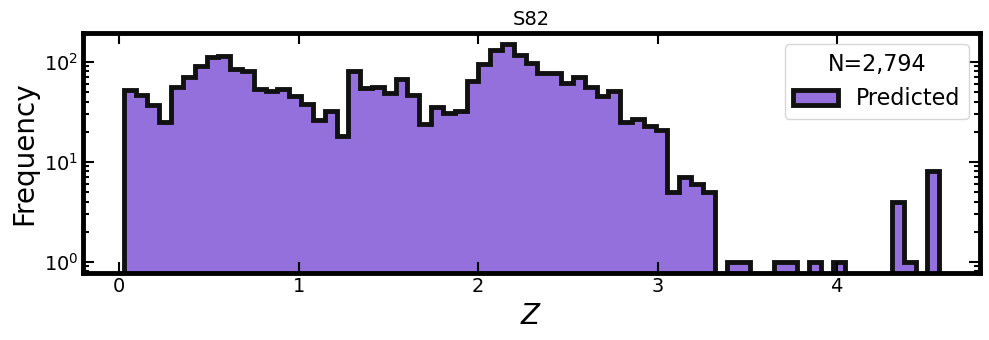

In [108]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_naive_{used_area}_unknown.pdf')
plt.show()

Predictions from probabilities.

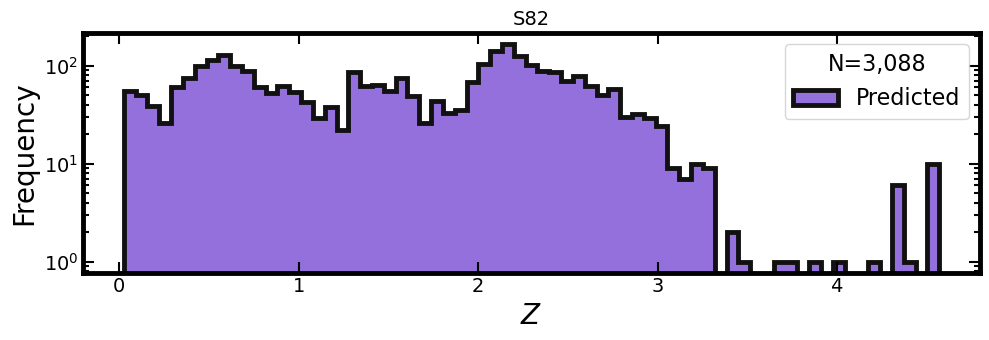

In [109]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_prob_naive_{used_area}_unknown.pdf')
plt.show()